In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os


In [51]:
# Directory containing CSV files
directory = 'data/'

# List to store DataFrames
dfs = []

# Loop through each CSV file in the directory
for filename in os.listdir(directory):
    if filename.endswith('.csv'):
        # Read the CSV file into a DataFrame and append it to the list
        filepath = os.path.join(directory, filename)
        df = pd.read_csv(filepath)
        dfs.append(df)

# Concatenate all DataFrames in the list into a single DataFrame
combined_df = pd.concat(dfs, ignore_index=True)


In [52]:
# Group the DataFrame by the 'beta' column
grouped_df = combined_df.groupby('beta')

# Create an empty dictionary to store the arrays
beta_arrays = {}

# Iterate over the groups
for beta, group in grouped_df:
    # Store the group as an array in the dictionary
    beta_arrays[beta] = group.to_numpy()


In [62]:
def plotter(depVar, col, sweepRange):
    """Function plot dependant variable against number of sweeps
    dependantVar: give string that dependant variable will be called
    col: column index of dependant variable starting from 0
    sweepRange: range over which sweeps are plotted
    """
    
    # plt.figure(figsize=(8, 6))  # Width: 8 inches, Height: 6 inches
    plt.rcParams['figure.figsize'] = [6.4, 4.8]  # [width, height] in inches
    
    for beta, array in beta_arrays.items(): 
        
        # find number of seeds iterated over
        max_seed = 0
        for i in range(len(array)):
            if array[i][5] > max_seed:
                max_seed = int(array[i][5]) 

        # I don't know why I have to put this in
        max_seed += 2

        # magnetisation array for task 1
        # columns are: sweeps, magnetisation, error
        independentVar = np.zeros(max_seed)
        dependantVar = np.zeros(max_seed)

        # independentVar = np.zeros(200)
        # dependantVar = np.zeros(200)

        # errors
        value_squares = np.zeros(max_seed)
        # value_squares = np.zeros(200)
        value_errors = []


        # iterates over every beta value
        
        for i in range(len(array)):
            
            j = int(array[i][0])
            # appends sweeps
            independentVar[j] = array[i][0]
            # appends dependantVar
            dependantVar[j] += array[i][col] / 50
            # appends dependantVar squared for error stuff
            value_squares[j] += array[i][col]**2 / 50

        prefactor = 1 / ( np.sqrt( max_seed) -1 ) 
        for k in range(len(value_squares)):
            value_errors.append( prefactor * np.sqrt(value_squares[k] - dependantVar[k]**2) )
                        
        # slice arrays for plotting
        independentVar = independentVar[:sweepRange+1]
        dependantVar = dependantVar[:sweepRange+1]
        value_errors = value_errors[:sweepRange+1]
        
        # convert to dimensionless temperature
        T_0 = 1/beta
        
        plt.errorbar(independentVar, dependantVar, yerr=value_errors, fmt='o', capsize=3, label=beta)
        
        # plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
        plt.legend(loc='lower right')
        # Set tick parameters inwards
        plt.tick_params(axis='both', direction='in')
        plt.xlabel('Sweeps')
        plt.xlim(0, sweepRange)

        plt.ylabel(depVar)
        plt.title(f'{depVar} vs Sweeps')
   
    plt.savefig(f"figures/task1_{depVar}.png")
    plt.show()

    return 

    

/var/folders/j0/4jbn0h55721bgq7ld4mp7qjw0000gn/T/ipykernel_31613/4161245381.py:50: RuntimeWarning: invalid value encountered in sqrt
  value_errors.append( prefactor * np.sqrt(value_squares[k] - dependantVar[k]**2) )
/var/folders/j0/4jbn0h55721bgq7ld4mp7qjw0000gn/T/ipykernel_31613/4161245381.py:50: RuntimeWarning: invalid value encountered in sqrt
  value_errors.append( prefactor * np.sqrt(value_squares[k] - dependantVar[k]**2) )
/var/folders/j0/4jbn0h55721bgq7ld4mp7qjw0000gn/T/ipykernel_31613/4161245381.py:50: RuntimeWarning: invalid value encountered in sqrt
  value_errors.append( prefactor * np.sqrt(value_squares[k] - dependantVar[k]**2) )
/var/folders/j0/4jbn0h55721bgq7ld4mp7qjw0000gn/T/ipykernel_31613/4161245381.py:50: RuntimeWarning: invalid value encountered in sqrt
  value_errors.append( prefactor * np.sqrt(value_squares[k] - dependantVar[k]**2) )
/var/folders/j0/4jbn0h55721bgq7ld4mp7qjw0000gn/T/ipykernel_31613/4161245381.py:50: RuntimeWarning: invalid value encountered in sqrt

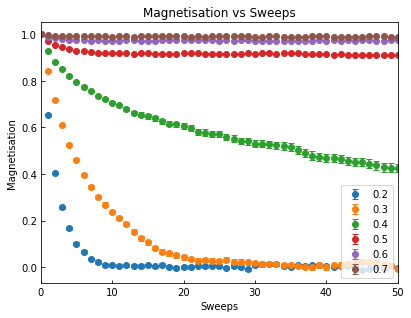

In [63]:
plotter("Magnetisation", 2, 50)

In [55]:
plotter("Energy", 3)

TypeError: plotter() missing 1 required positional argument: 'sweepRange'